In [1]:
# JG 10/24/17
# Sanity Check for ibp data
# questions/functionality
# 1. Linking vsearch names to metadata file (any changes needed?)
# 2. Sequence recovery by well (in the context of missing samples, spatial autocorrelation, etc.)
# 3. intra-replicate BD (basically plot histograms of replicate and non-replicate BD)
# 4. Incorporate our metadata into a/b diversity figs
# 5. Export reduced metadata and BD files.

2/12/18 notes/todo:
1. Color samples in WUF plot by soiltype and test with anosim if it looks cool, 
2. direct comparison of this with a mantel test / multivariate regression tree analysis
3. Soil grade and depth seem to basically control everything, which is dope.
4. How is soil type graded? Good to know for later. 

In [32]:
# imports and finished functions
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl
%matplotlib inline

from skbio import stats
import skbio
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm

### Load data and Manipulate string names

In [8]:
# Load data
bd_matrix = pd.read_csv('../Seq_data/vsearch/beta/weighted_unifrac_dm.txt', sep='\t',  index_col=0)
map_df2 = pd.read_csv('../Metadata/Metadata_IBP_w_pH.txt', sep='\t')
#map_df = pd.read_csv('../Metadata/Metadata-IBP_3.txt', sep='\t')
map_df = pd.read_csv('../Metadata/ibp_metadata_2.6.18_version.txt', sep='\t')

In [5]:
# Eliminate columns from the BD file that do not contain sample metadata:

# Do a quick check to see if names in map_df and bd_matrix map to one another:
map_file_but_not_bd_mat = []
bd_mat_but_not_map_file = []
for i in map_df3['#SampleID']:
    if i in bd_matrix.index:
        pass
    else:
        map_file_but_not_bd_mat.append(i)

for i in bd_matrix.index:
    #print(i)
    #break
    if i in map_df3['#SampleID'].values:
        pass
    else:
        print(i)
        bd_mat_but_not_map_file.append(i)
 
# Make reduced BD dataframe with just the common samples: 
bd_col_short = [x for x in bd_matrix.columns.values if x not in bd_mat_but_not_map_file]
bd_mat_reduced = bd_matrix.loc[bd_col_short, bd_col_short]

W11.D10.rB
W11.D10.rA
W11.D5.rB
W11.D3.rB
W11.D3.rA
N/A.Plate1B3
W11.D5.rA
W11.D7.rB
W11.D9.rA
W11.D9.rB
N/A.Plate1D1
N/A.Plate1D3
W11.D8.rB
W11.D8.rA
W11.D11.rA
W11.D1.rA
W11.D11.rB
W11.D4.rA
W11.D2.rA
W11.D2.rB
W11.D6.rA
W11.D1.rB
W11.D7.rA
W11.D6.rB
W11.D4.rB
W11.D12.rA
W11.D12.rB
N/A.Plate3C6


In [9]:
# Sample name manipulation so that everything is directly comparable without any 'r's. 

# Remove 'r' from mapfile as well:
new_inds = []
for i in map_df['#SampleID'].values:
    if i.startswith('W'):
        split = i.rsplit('.', 1)
        new_inds.append( split[0]+'.'+split[1][-1] )
    else:
        new_inds.append(i)
print(len(new_inds))
print(len(map_df))
map_df['#SampleID'] = new_inds

# Some samples missing 'r' because Im dumb. Stripped all of the r and now just have "W#(sensor).D#(depth).#replicate"
new_cols = {}
for i in bd_col_short:
    split = i.rsplit('.', 1)
    new_name = split[0]+'.'+split[1][-1]
    new_cols[i] = new_name
bd_mat_reduced.rename(new_cols,new_cols, inplace=True)

# Reindexing map dataframe to use the same indices as reduced beta diversity matrix
reindexed_map = map_df.set_index('#SampleID')
reindexed_map = reindexed_map.reindex([bd_mat_reduced.index])


### Adding pH Data to main environmental dataframe:
map_df2_short = map_df2.iloc[:110,:25]
map_df2_short
for i,row in map_df2_short.iterrows():
    sample_name = 'W' + str(int(row['Well'])) + '.D' + str(int(row['section ']))
    if sample_name+'.A' in reindexed_map.index:
        reindexed_map.loc[sample_name+'.A', 'pH'] = row['pH ']
        reindexed_map.loc[sample_name+'.A', 'USDA_soil_type'] = row['USDA_Soil Series']
    if sample_name+'.B' in reindexed_map.index:
        reindexed_map.loc[sample_name+'.B', 'pH'] = row['pH ']
        reindexed_map.loc[sample_name+'.B', 'USDA_soil_type'] = row['USDA_Soil Series']

240
240


/Users/jimbo/anaconda3/envs/qiime2-latest/lib/python3.5/site-packages/ipykernel_launcher.py:21: FutureWarning: Intepreting call
	'.rename(a, b)' as 
	'.rename(index=a, columns=b)'.
Use named arguments to remove any ambiguity. In the future, using positional arguments for 'index' or 'columns' will raise  a 'TypeError'.


### Ordinations
I may have to redo the ordination with my environmental variables, but for now what do samples look like?
todo:
1. raw pcoa w/ WU distances colored by depth, site, soil type, elevation, inundation fraction

In [10]:
#### Making Colormaps!
# Let's make lists ordered by the same indices as my bd_mat_reduced matrix that correspond to depth, well, pH, inundation, etc.
# step 1. Reindexex map_df (above) and can now operate on individual columns.

# step 2, make color maps (easy first): 
# 1. Site (10 values, already ints, ranging from 1-10)
loc_color = sns.color_palette("Spectral", 10)
loc_as_color = [loc_color[x-1] for x in reindexed_map['WLWNum']]

# 2. Depth: 12 values, floats.
# Answer here: https://stackoverflow.com/questions/28752727/map-values-to-colors-in-matplotlib

# First, Removing nans using the index name since it contains depth:
for i,row in reindexed_map.iterrows():
    if np.isnan(row['Depth']):
        d_val = i.split('.')[1][1]
        reindexed_map.loc[i, 'Depth'] = float(d_val)/10.0

#. Now apply colormap:
minima = min(reindexed_map['Depth'])
maxima = max(reindexed_map['Depth'])
# Create a Normalize & colormap object


norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Spectral)
depth_as_color = [mapper.to_rgba(x) for x in reindexed_map['Depth']]


# 3. Inundation Fraction:
minima = min(reindexed_map['Inundation_Frac'])
maxima = max(reindexed_map['Inundation_Frac'])

norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Spectral)
inundation_as_color = [mapper.to_rgba(x) for x in reindexed_map['Inundation_Frac']]


TypeError: list indices must be integers or slices, not float

/Users/jimbo/anaconda3/envs/qiime2-latest/lib/python3.5/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.10391679910559314 and the largest is 4.748572201442543.
  RuntimeWarning


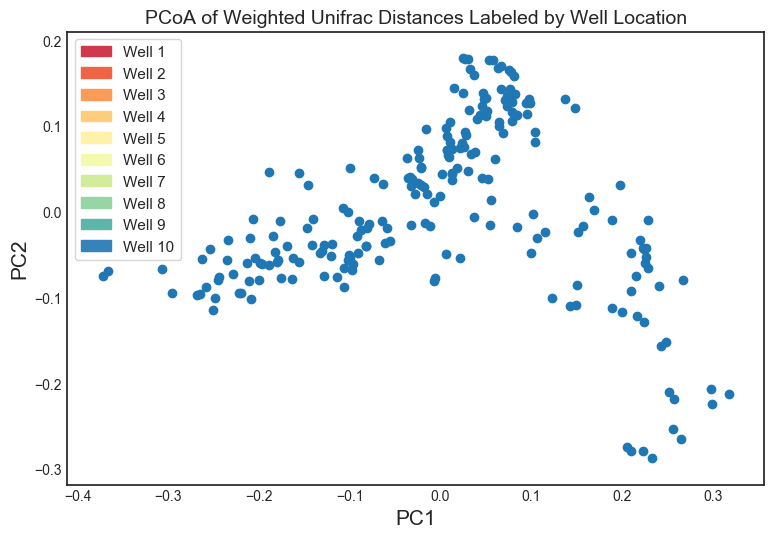

In [12]:


# PCoA + Weighted Unifrac (What did I do to preprocess the data?)
wu_pcoa = stats.ordination.pcoa(bd_mat_reduced)

# Plotting in 2D with various features highlighted:
sns.set_style('white')
f,ax = plt.subplots()
ax.scatter(wu_pcoa.samples['PC1'], wu_pcoa.samples['PC2']), c=loc_as_color, s=40)
ax.set_ylabel('PC2', fontsize=15)
ax.set_xlabel('PC1', fontsize=15)
ax.set_title('PCoA of Weighted Unifrac Distances Labeled by Well Location', fontsize=14)

# legend
patches = []
for i in range(10):
    patches.append( mpatches.Patch(color=loc_color[i], label='Well {0}'.format(i+1)) )
ax.legend(loc=2, handles = patches, fontsize=11, frameon=True)
#f.savefig('../output/PCoA_well.png')


NameError: name 'wu_pcoa' is not defined

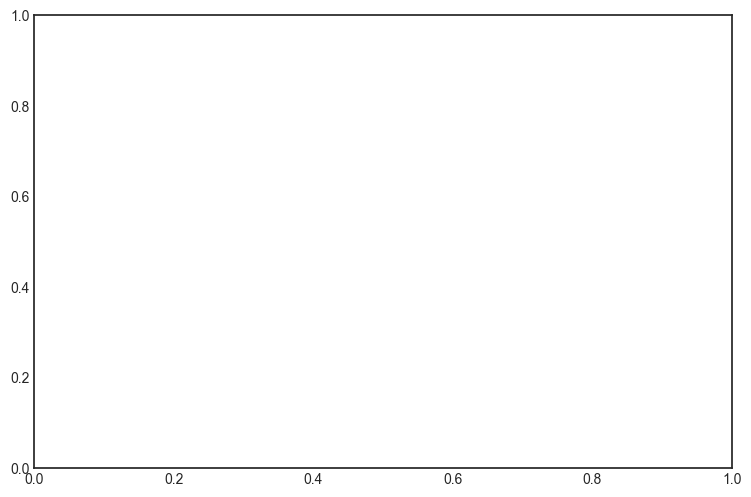

In [7]:

sns.set_style('white')
f,ax = plt.subplots()
#points = ax.scatter(wu_pcoa.samples['PC1'], wu_pcoa.samples['PC2'], c=depth_as_color, s=40)
#ax.set_title('PCoA of Weighted Unifrac Distance Labeled by Depth', fontsize=14)

points = ax.scatter(wu_pcoa.samples['PC1'], wu_pcoa.samples['PC2'], c=inundation_as_color, s=40)
ax.set_title('PCoA of Weighted Unifrac Distance Labeled by Inundation Fraction', fontsize=14)


ax.set_ylabel('PC2', fontsize=15)
ax.set_xlabel('PC1', fontsize=15)

sm = plt.cm.ScalarMappable(cmap='Spectral', norm=plt.Normalize(vmin=0, vmax=1.))
sm._A = []
colorbar = plt.colorbar(sm)
f.tight_layout()
#f.savefig('../output/PCoA_by_inundation.png')
#f.savefig('../output/PCoA_by_depth.png')


In [188]:
#### Redoing ordination as a biplot using CCA
# Q1) Normalize all my variables yes or no? Not necessary apparently?

# 2. Need to make an environmental variable matrix with n rows (samples) and q variables.
# Subset to potentially important columns (does not include site variable.)
columns = ['Depth', 'pH', 'Pb_Con', 'Inundation_Frac', 'Elevation', 'Ca_Conc', 'USDA_soil_type', 'P_Conc', 'Dist_Ext_WT']
reduced_map = reindexed_map[columns]
# Split USDA_soil_type variable into 3 columns.
reduced_map['SelmaLoam'] = 0
reduced_map['LFS'] = 0
reduced_map['FSL'] = 0
reduced_map['SelmaLoam'] = np.where(reduced_map['USDA_soil_type'] == 'Selma loam ', 1, 0)
reduced_map['LFS'] = np.where(reduced_map['USDA_soil_type'] == 'Watseka loamy fine sand ', 1, 0)
reduced_map['FSL'] = np.where(reduced_map['USDA_soil_type'] == 'Hoopeston fine sandy loam ', 1, 0)
reduced_map = reduced_map.drop('USDA_soil_type', axis=1)


Index(['BarcodeSequence', 'LinkerPrimerSequence', 'Well', 'WLWNum', 'MicroNum',
       'Cumm_Depth', 'Elevation', 'Depth', 'Soil_Type', 'Dist_Ext_WT',
       'Inundation_Frac', 'Dry_Frac', 'Pb_Con', 'CU_Conc', 'Fe_Conc',
       'Zn_Conc', 'Ca_Conc', 'K_conc', 'Mg_Conc', 'P_Conc', 'Na_Conc',
       'Description', 'pH'],
      dtype='object')

In [224]:
reduced_map.fillna(reduced_map.mean(), inplace=True)

cca_results = stats.ordination.cca(bd_mat_reduced,reduced_map, scaling=1)

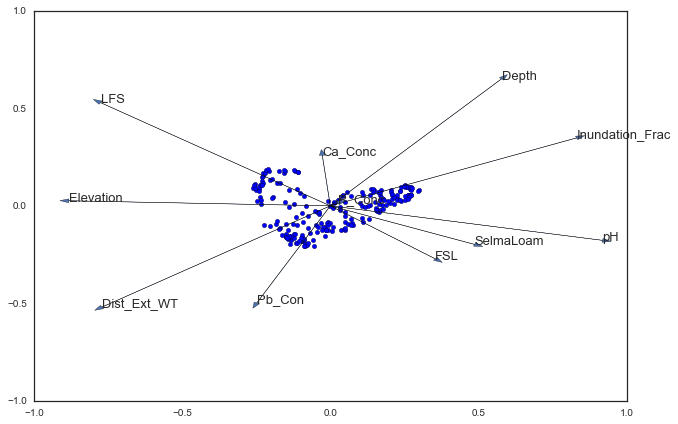

In [263]:
f,ax = plt.subplots()
#ax.scatter(cca_results.sample_constraints['CCA1'], cca_results.sample_constraints['CCA2'])
ax.scatter(cca_results.samples['CCA1'], cca_results.samples['CCA2'])
for i,row in cca_results.biplot_scores.iterrows():
    ax.arrow(0,0, row['CCA1'], row['CCA2'])
    ax.annotate(i, xy=(row['CCA1'], row['CCA2']), fontsize=13) 
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
f.tight_layout()
f.savefig('../output/CCA_attempt.png')

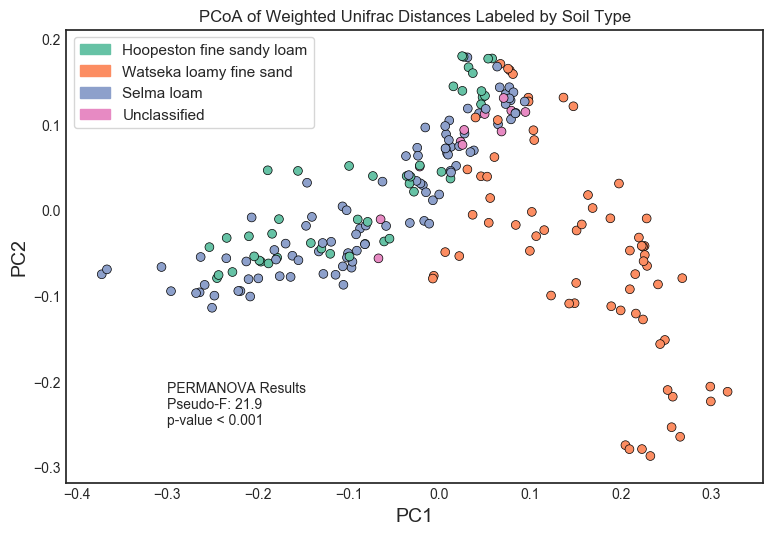

In [48]:
# Plot BD colored by soil type:
colors = {'Hoopeston fine sandy loam ':sns.color_palette('Set2', 4)[0], 
                 'Watseka loamy fine sand ':sns.color_palette('Set2', 4)[1], 
                 'Selma loam ':sns.color_palette('Set2', 4)[2] }
color_vector = []
labels = ['Hoopeston fine sandy loam', 'Watseka loamy fine sand', 'Selma loam', 'Unclassified']
soil_colors = sns.color_palette('Set2', 4)

for i in bd_mat_reduced.index:
    soil_type = map_df[ map_df['#SampleID'] == i]['USDA_Soil Series'].values[0]
    if soil_type in colors.keys():
        color_vector.append(colors[soil_type])
    else:
        color_vector.append(sns.color_palette('Set2', 4)[3])

# Plotting
sns.set_style('white')
f,ax = plt.subplots()
ax.scatter(wu_pcoa.samples['PC1'], wu_pcoa.samples['PC2'], c=color_vector, s=40, edgecolors='k', linewidths=.5)
ax.set_ylabel('PC2', fontsize=14)
ax.set_xlabel('PC1', fontsize=14)
ax.set_title('PCoA of Weighted Unifrac Distances Labeled by Soil Type', fontsize=12)

# Legend:
patches = []
for i in range(4):
    patches.append( mpatches.Patch(color=soil_colors[i], label=labels[i] ))
    ax.legend(loc=2, handles = patches, fontsize=11, frameon=True)
    
ax.annotate('PERMANOVA Results\nPseudo-F: 21.9\np-value < 0.001', xy=(-.3, -.25))
#f.savefig('../output/PCoA_by_soil_type.png', dpi=300)

In [42]:
# permanova by soil type
soil_type_dict = colors = {'Hoopeston fine sandy loam ':0, 
                 'Watseka loamy fine sand ':1, 
                 'Selma loam ':2,
                 'Unclassified':3}

soil_list = []
for i in bd_mat_reduced.index:
    soil_type = map_df[ map_df['#SampleID'] == i]['USDA_Soil Series'].values[0]
    if soil_type in soil_type_dict.keys():
        soil_list.append(soil_type)
    else:
        soil_list.append('Unclassified')
    

wu_distance_mat = skbio.DistanceMatrix(bd_mat_reduced, ids=bd_mat_reduced.index)
stats.distance.permanova(wu_distance_mat, grouping=soil_list)


method name               PERMANOVA
test statistic name        pseudo-F
sample size                     219
number of groups                  4
test statistic              21.9494
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

In [ ]:
# multifactor model, how to build this?

### Replicate Similarity

In [6]:
# Now that I have a consistently named bd dataframe, check replicate accuracy:
non_replicates = []
replicates = []

#
for i in range(len(bd_mat_reduced)):
    for j in range(i+1,len(bd_mat_reduced)):
        col = bd_mat_reduced.columns[j].rsplit('.',1)[0]
        ind = bd_mat_reduced.index[i].rsplit('.',1)[0]
        if col==ind:
            replicates.append( bd_mat_reduced.ix[i,j] )
        else:
            non_replicates.append( bd_mat_reduced.ix[i,j])


/Users/jimbo/anaconda/envs/qiime2-2017.10/lib/python3.5/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


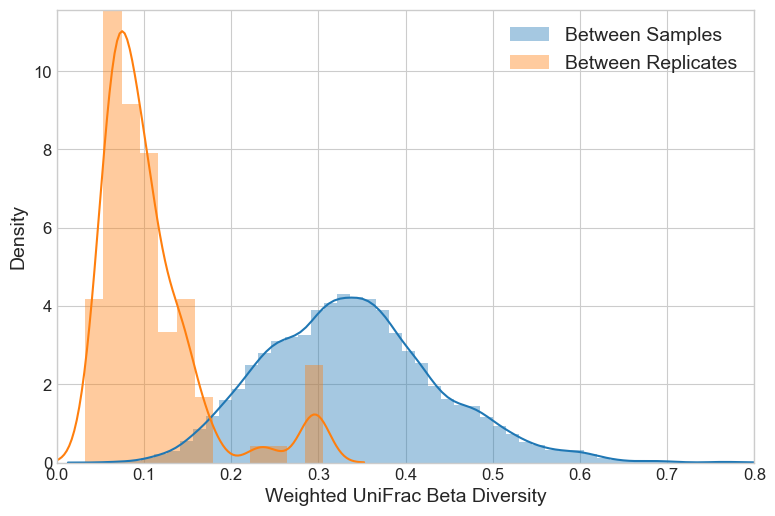

In [7]:
sns.set_style('whitegrid')
f,ax = plt.subplots()

sns.distplot(non_replicates, label= 'Between Samples')
sns.distplot(replicates, label= 'Between Replicates')
ax.set_xlim([0,.8])
ax.set_ylabel('Density', fontsize=14)
ax.set_xlabel('Weighted UniFrac Beta Diversity', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=14)
#plt.savefig('../output/replicate_beta_diversity.png')
#ax.annotate(xy =[10,.5], text='Replicates were highly similar, except in a few cases caused by low sequencing depth')

In [ ]:
# Super Simple Comparison of BD with wetness and depth:

/Users/jimbo/anaconda/envs/qiime2-2017.10/lib/python3.5/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


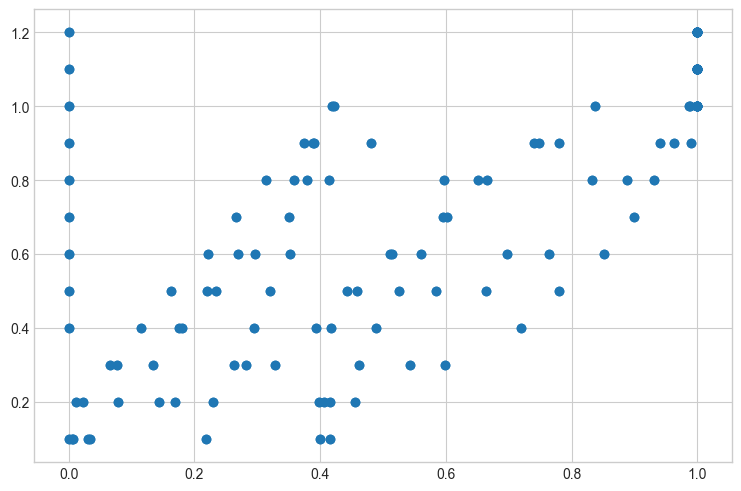

In [8]:
# So... What correlates with BD observed in samples?
# Depth, wetness, historical wetness, other stuff?



f,ax = plt.subplots()
ax.scatter( map_df.ix[:,'Inundation_Frac'], map_df.ix[:,'Depth'] )

In [132]:
# Making deltaEcological Variable matrices:

depth_delta = np.empty((len(bd_mat_reduced),len(bd_mat_reduced)))
cur_water_delta = np.empty([len(bd_mat_reduced),len(bd_mat_reduced)])
hist_water_delta = np.empty([len(bd_mat_reduced),len(bd_mat_reduced)]) # May need to throw out the ones with no sensor data
depth_delta[:] = np.nan
cur_water_delta[:] = np.nan
hist_water_delta[:] = np.nan


for i in range(len(bd_mat_reduced)):
    for j in range(i+1,len(bd_mat_reduced)):
        row_1 = map_df[ map_df['#SampleID'] == bd_mat_reduced.index[i] ]
        row_2 = map_df[ map_df['#SampleID'] == bd_mat_reduced.index[j] ]
        #if not (len(row_1) == 1 and len(row_2 == 1)):
        if len(row_1) == 1 and len(row_2) ==1: 
            depth_delta[i,j] = abs (row_1['Depth'].values[0] - row_2['Depth'].values[0] ) 
            cur_water_delta[i,j] = abs (row_1['Dist_Ext_WT'].values[0] - row_2['Dist_Ext_WT'].values[0] )
            hist_water_delta[i,j] = abs (row_1['Inundation_Frac'].values[0] - row_2['Inundation_Frac'].values[0] )
        else:
            print(len(row_1))
            print(len(row_2))

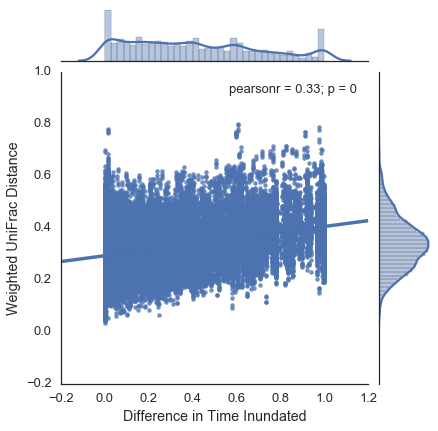

In [166]:
# Plotting BD as a function of ecological gradients:
# get upper triangle matrices?
#depth_delta

# Need to get upper triangles as flat lists.
flat_depth_delta = depth_delta.flatten()
flat_hist_water_data = hist_water_delta.flatten()
flat_cur_water_delta = cur_water_delta.flatten()
flat_wu_data = bd_mat_reduced.as_matrix().flatten()


#print(len(flat_depth_delta))
#print(len(flat_wu_data))

sns.set_style('white')
sns.set_context('talk')
g = sns.jointplot(flat_hist_water_data,  flat_wu_data, kind="regression")
g.set_axis_labels('Difference in Time Inundated', 'Weighted UniFrac Distance')
#g.savefig('../output/WU_vs_delta_time_inundated.png')


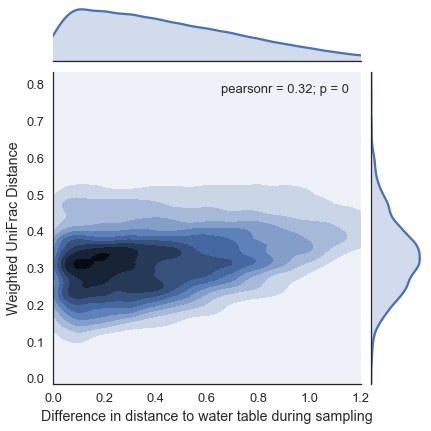

In [162]:
g = sns.jointplot(flat_cur_water_delta,  flat_wu_data, kind="kde", xlim=(0, 1.2))
g.set_axis_labels('Difference in distance to water table during sampling', 'Weighted UniFrac Distance')
g.savefig('../output/WU_data_vs_delta_watertable_dist.png')

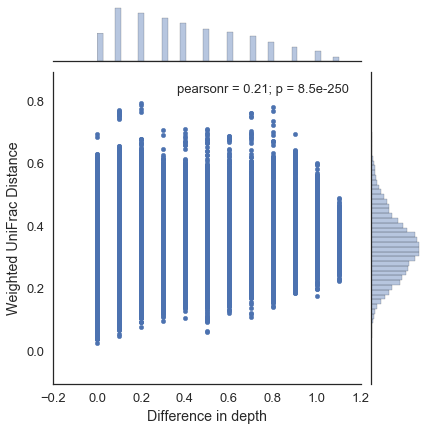

In [167]:
g = sns.jointplot(flat_depth_delta,  flat_wu_data, kind="scatter")
g.set_axis_labels('Difference in depth', 'Weighted UniFrac Distance')
g.savefig('WU_vs_delta_depth.png')

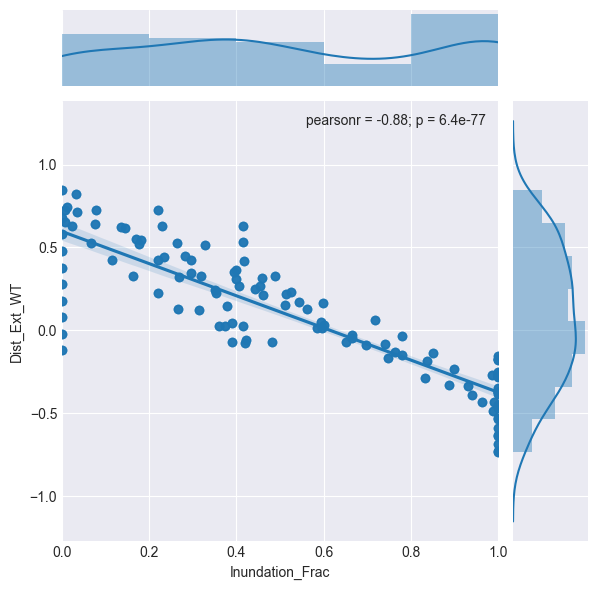

In [148]:
map_df.columns
##f,ax = plt.subplots()

sns.jointplot(map_df['Inundation_Frac'], map_df['Dist_Ext_WT'], kind='regression', xlim=(0,1))

In [78]:
# BD vs depth for each well:
bd_by_depth_mat = np.zeros( (12,10) )
bd_by_depth_mat

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [105]:
# Trying to find all possibilities
fail = []
for i in range(10):
    upper_rep_A = 'W{0}.D1.A'.format(i+1) 
    upper_rep_B = 'W{0}.D1.B'.format(i+1)
    
    for j in range(12):
        id_base = 'W{0}.D{1}'.format(i+1,j+1)
        lower_rep_A = id_base + '.A'
        lower_rep_B = id_base + '.B'
        
        vals = []
        if upper_rep_A in bd_mat_reduced.index and lower_rep_A in bd_mat_reduced.index:
            vals.append(bd_mat_reduced.ix[upper_rep_A, lower_rep_A])
        if upper_rep_A in bd_mat_reduced.index and lower_rep_B in bd_mat_reduced.index:  
            vals.append(bd_mat_reduced.ix[upper_rep_A, lower_rep_B])
        if upper_rep_B in bd_mat_reduced.index and lower_rep_A in bd_mat_reduced.index:
            vals.append(bd_mat_reduced.ix[upper_rep_B, lower_rep_A])
        if upper_rep_B in bd_mat_reduced.index and lower_rep_B in bd_mat_reduced.index:
            vals.append(bd_mat_reduced.ix[upper_rep_B, lower_rep_B])
        
        if len(vals) != 0:
            bd_by_depth_mat[j,i] = np.mean(vals)
        elif len(vals) != 0:
            bd_by_depth_mat[j,i] = None


        
        
   # break

In [135]:
np.mean(bd_by_depth_mat, axis=1)

array([ 0.02991066,  0.16153426,  0.22577636,  0.25270126,  0.26450224,
        0.28977834,  0.24465688,  0.31054696,  0.36112596,  0.30941689,
        0.36111718,  0.32866852])

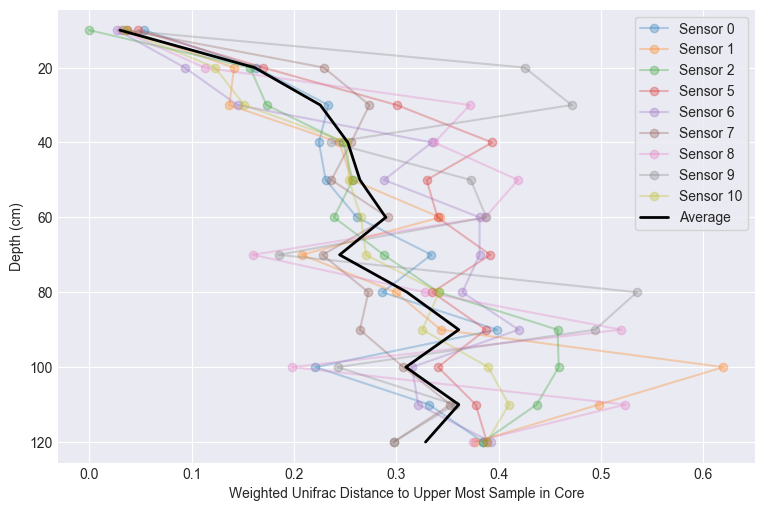

In [147]:
sns.set_style('darkgrid')
f,ax = plt.subplots()
depth = np.linspace(10,120,12)
bd_by_depth_mat[6,5] = bd_by_depth_mat[5,5]

for i in range(3):
    ax.plot(bd_by_depth_mat[:,i], depth, marker='o',alpha=.3,label='Sensor {0}'.format(i))
for i in range(4,10):
    ax.plot(bd_by_depth_mat[:,i], depth, marker='o',alpha=.3,label='Sensor {0}'.format(i+1))
ax.plot(np.mean(bd_by_depth_mat, axis=1), depth, color='k', label='Average', lw=2)
ax.legend(frameon=True)
ax.set_ylabel('Depth (cm)')
ax.set_xlabel('Weighted Unifrac Distance to Upper Most Sample in Core')
ax.invert_yaxis()
f.savefig('../output/BD_by_depth.png', dpi=300)

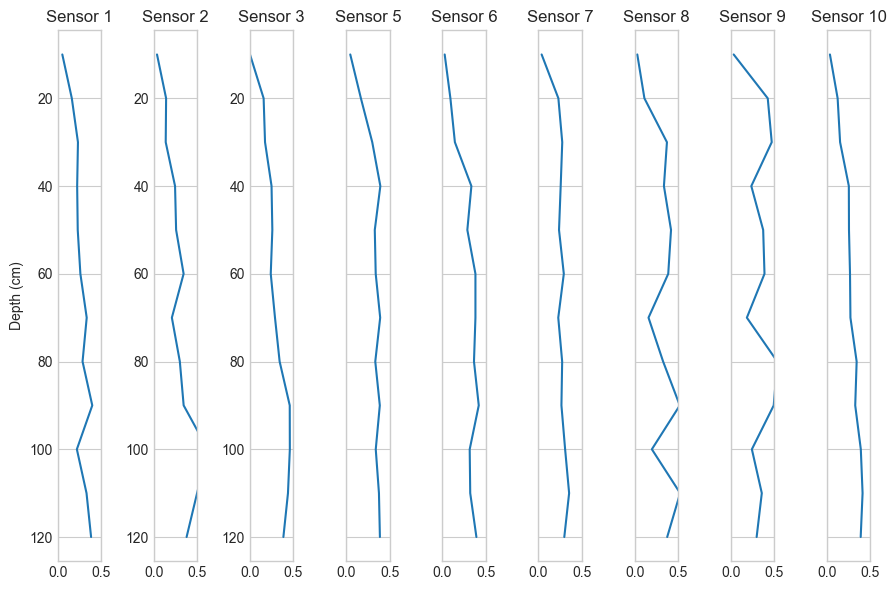

In [127]:
f,axs = plt.subplots(1,9)
axs.reshape(-1)
depth = np.linspace(10,120,12)
bd_by_depth_mat[6,5] = bd_by_depth_mat[5,5]

for i in range(3):
    axs[i].plot(bd_by_depth_mat[:,i], depth)
    axs[i].invert_yaxis()
    axs[i].set_title('Sensor {0}'.format(i+1))
    axs[i].set_xlim(0,.5)
    
for i in range(4,10):
    axs[i-1].plot(bd_by_depth_mat[:,i], depth)
    axs[i-1].yaxis.set_ticklabels([])
    axs[i-1].invert_yaxis()
    axs[i-1].set_title('Sensor {0}'.format(i+1))
    axs[i-1].set_xlim(0,.5)
    

axs[0].set_ylabel('Depth (cm)')
f.tight_layout()

In [111]:
bd_by_depth_mat[6,5]

0.0

In [86]:
depth = np.linspace(0,120,12)


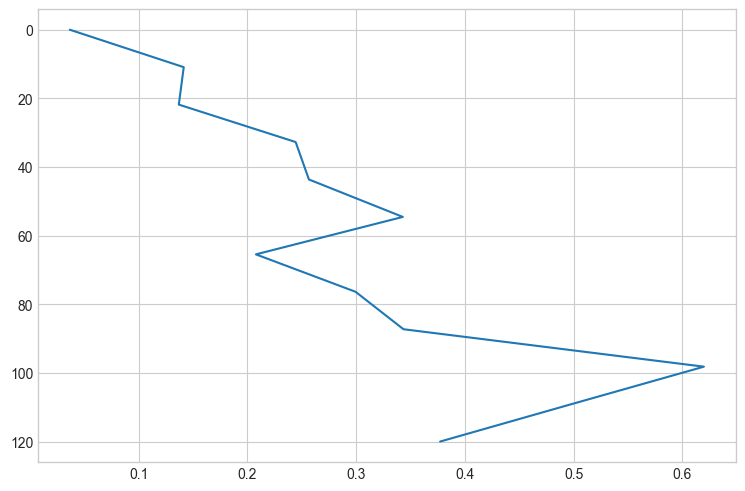

In [88]:
f,ax = plt.subplots()
ax.plot(bd_by_depth_mat[:,1],depth)
ax.invert_yaxis()